In [1]:
import polars as pl
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from utils import remove_extra_brackets

In [2]:
df = pl.read_csv("../data/train.csv")

We can see that we have a lot  of column but we must keep in mind that in the test dataset we will only be provided with **prompt**, **response_a** and **response_b**.

From initial observation we can see that prompt, response_a and response_b are enclosed in a list containing the text so we must fix that!
Further more the winner is provided in columns **winner_model_a**,**winner_model_b** and **winner_tie** with the correct option highlighted as 1 and the rest are 0.

In [3]:
text = df["prompt"].sample(1)[0]
print(f"{'Prompt':<12}: {text}")
text = df["response_a"].sample(1)[0]
print(f"{'Response_a':<12}: {text}")
text = df["response_b"].sample(1)[0]
print(f"{'Response_b':<12}: {text}")

Prompt      : ["Rewrite this sentence to sound much better: \"Then, we show how CurveML can be equally learned by a family of PointNet-based models to learn the same tasks\"."]
Response_a  : ["This is a famous line from Shakespeare's play \"Hamlet,\" and it is a question that has been debated for centuries. The line comes from Hamlet's soliloquy in which he is contemplating the idea of suicide. He is considering whether it is better to suffer through the hardships of life or to take action against them.\n\nOn one hand, it might be argued that it is nobler in the mind to suffer. This could mean accepting one's fate and accepting the challenges that life brings. By accepting one's suffering, one might find inner peace and a sense of acceptance.\n\nOn the other hand, it could be argued that it is nobler to take arms against a sea of troubles. This could mean taking action to try to change one's circumstances and to try to overcome the challenges that life brings. By taking action, one mig

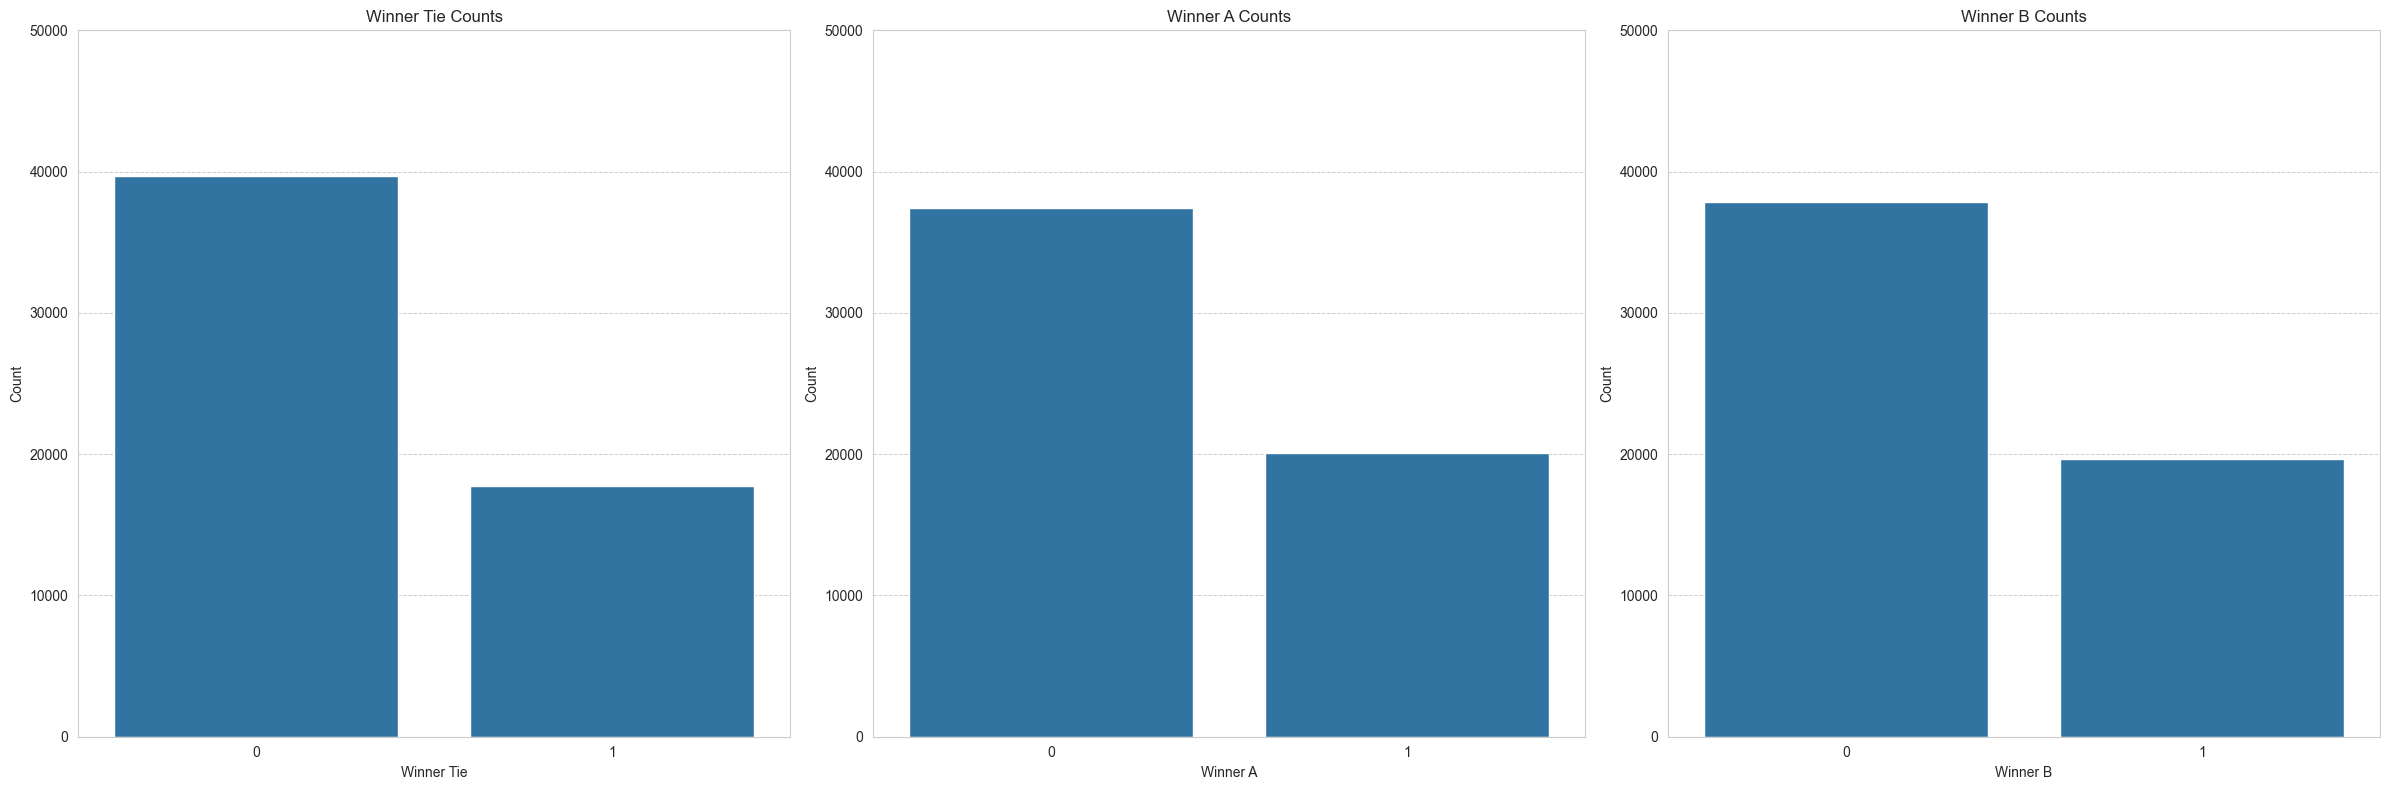

In [4]:
fig, ax = plt.subplots(1,3, figsize=(24, 8))
yticks = np.arange(0, 55000, 10000)

sns.countplot(x=df["winner_tie"].to_list(), ax=ax[0]);
ax[0].set_title("Winner Tie Counts")
ax[0].set_xlabel("Winner Tie")
ax[0].set_ylabel("Count")
ax[0].set_yticks(yticks)
ax[0].grid(axis='y',  which='major', linestyle='--', linewidth=0.7)

sns.countplot(x=df["winner_model_a"].to_list(), ax=ax[1]);
ax[1].set_title("Winner A Counts")
ax[1].set_xlabel("Winner A")
ax[1].set_ylabel("Count")
ax[1].set_yticks(yticks)
ax[1].grid(axis='y', which='major', linestyle='--', linewidth=0.7)

sns.countplot(x=df["winner_model_b"].to_list(), ax=ax[2]);
ax[2].set_title("Winner B Counts")
ax[2].set_xlabel("Winner B")
ax[2].set_ylabel("Count")
ax[2].set_yticks(yticks)
ax[2].grid(axis='y', which='major', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

As we can see the dataset is already balanced as there is no evidence of users prefering the option 1 more that option 2 which i have seen in a research paper that was detected.

In [5]:
df = df.with_columns([
    pl.col("prompt").map_elements(remove_extra_brackets, return_dtype=pl.String),
    pl.col("response_a").map_elements(remove_extra_brackets, return_dtype=pl.String),
    pl.col("response_b").map_elements(remove_extra_brackets, return_dtype=pl.String),
])

In [6]:
df = df.with_columns(
    pl.when(pl.col('winner_model_a')==1).then(pl.col('model_a')).when(pl.col('winner_model_b')==1).then(pl.col('model_b')).otherwise(None).alias("final_winner")
)

In [7]:
models_a = df['model_a'].value_counts()
models_b = df['model_b'].value_counts()
winners = df['final_winner'].value_counts()

In [8]:
models = {}

for row in models_a.iter_rows():
    name = row[0]
    count = row[1]
    if name in models.keys():
        models[name] += count
    else:
        models[name] = count
        
for row in models_b.iter_rows():
    name = row[0]
    count = row[1]
    if name in models.keys():
        models[name] += count
    else:
        models[name] = count

In [9]:
models_used_df = pl.DataFrame([models]).unpivot(variable_name="model", value_name="count")

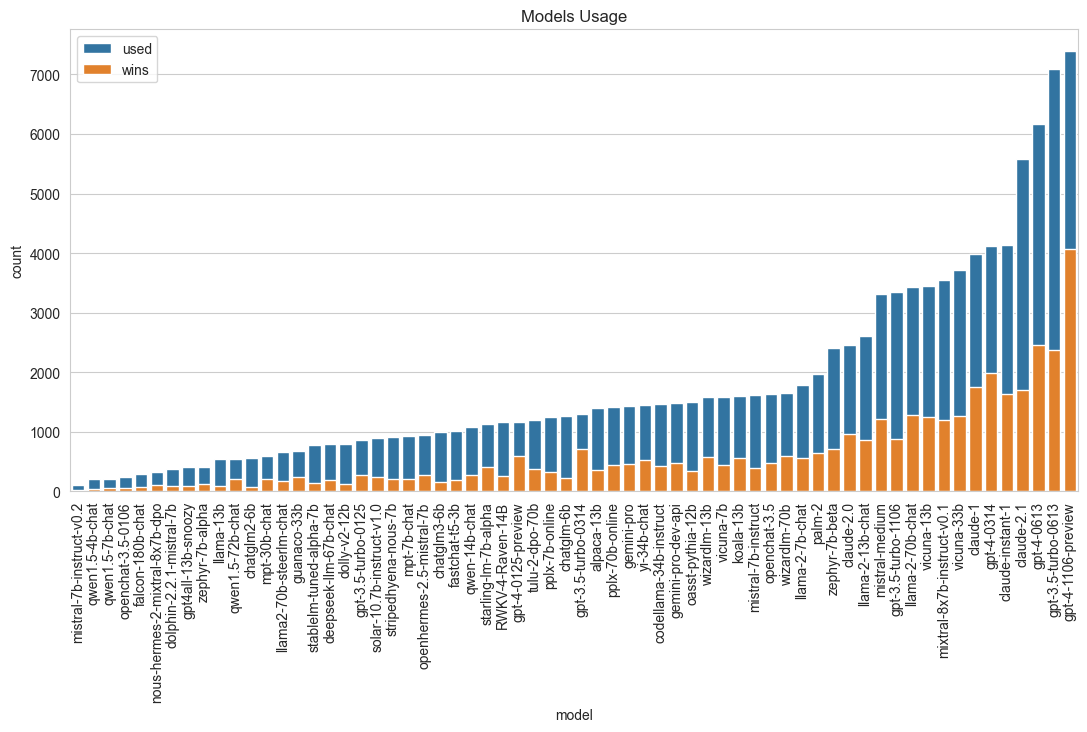

In [10]:
plt.figure(figsize=(13,6))
sns.barplot(models_used_df.sort("count"), x="model", y="count", label="used")
sns.barplot(winners, x="final_winner", y="count", label="wins")
plt.title("Models Usage")
plt.xticks(rotation=90);
plt.show()

In [18]:
final_model_leadearboard = models_used_df.join(winners, left_on="model", right_on="final_winner", suffix="_wins")

In [22]:
final_model_leadearboard = final_model_leadearboard.with_columns(
    ((pl.col("count_wins")/pl.col("count"))*100).alias("win_percentage")
)

C:\Users\User\AppData\Local\Temp\ipykernel_9372\2094008093.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#D3AF37'` for the same effect.

  sns.barplot(final_model_leadearboard.sort("win_percentage"), x="model", y="win_percentage", color="#D3AF37", hue="win_percentage");


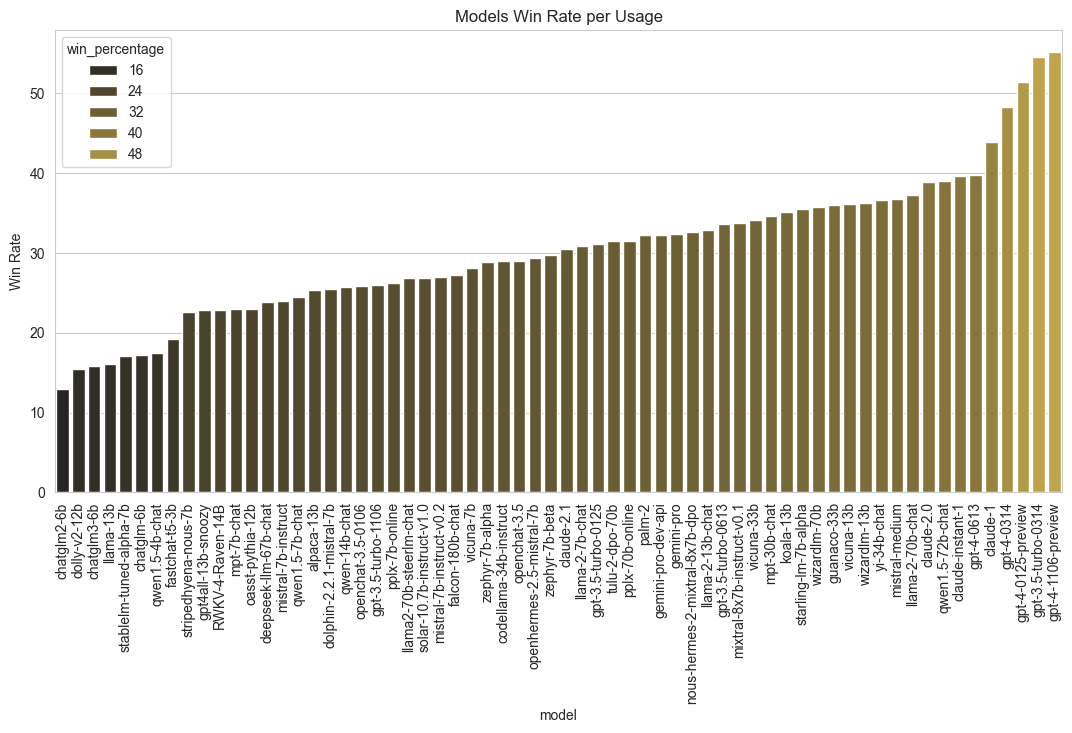

In [36]:
plt.figure(figsize=(13,6))
sns.barplot(final_model_leadearboard.sort("win_percentage"), x="model", y="win_percentage", color="#D3AF37", hue="win_percentage");
plt.title("Models Win Rate per Usage");
plt.ylabel("Win Rate")
plt.xticks(rotation=90);
plt.show()